# CUB 200 2011 - Feature Attributions

## What are feature ablations?

Consider a network and a specific input to this network (eg. an image, if the network is trained for image classification). The input is multi-dimensional, made of several features. In the case of images, each pixel can be considered a feature. The goal of an attribution method is to determine a real value R(x_i) for each input feature, with respect to a target neuron of interest (for example, the activation of the neuron corresponsing to the correct class).

When the attributions of all input features are arranged together to have the same shape of the input sample we talk about attribution maps (as in the picture below), where red and blue colors indicate respectively features that contribute positively to the activation of the target output and features having a suppressing effect on it.

This can help to better understand the network behavior, which features mostly contribute to the output and possible reasons for missclassification.

![Example](https://github.com/marcoancona/DeepExplain/blob/master/docs/comparison.png?raw=true)



In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

from itertools import product
from PIL import Image

from captum.insights import AttributionVisualizer, Batch
from captum.insights.features import ImageFeature
from captum.attr import IntegratedGradients, GuidedGradCam
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import GradientShap, DeepLiftShap, ShapleyValueSampling
from captum.attr import Occlusion
from captum.attr import visualization as viz

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeAggresiveTransforms, makeDefaultTransforms, resizeCropTransforms

In [2]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('gist_rainbow')(range(ncolors))

# change alpha values
ncolor_values = np.linspace(1,ncolors,ncolors)/ncolors
alphas = np.ones(ncolors)
alphas[ ncolor_values < 0.1 ] = 0.0
color_array[:,-1] = alphas

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

In [3]:
# Script runtime options
model = 'resnet152'
root_dir = '..'
data_root_dir = os.path.join(root_dir, 'data')
model_root_dir = os.path.join(root_dir, 'models')
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [4]:
# Get image transforms
# Get data transforms
data_transforms = resizeCropTransforms(img_crop_size=224, img_resize=512)

# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2, )
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

In [5]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


In [32]:
# Load the best model from file
model_ = torch.load(model_file)
_ = model_.to(device).eval()

In [33]:
def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

In [36]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


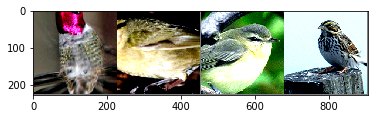

GroundTruth:  067.Anna_Hummingbird 181.Worm_eating_Warbler 153.Philadelphia_Vireo 127.Savannah_Sparrow
Predicted:  067.Anna_Hummingbird 181.Worm_eating_Warbler 153.Philadelphia_Vireo 127.Savannah_Sparrow


In [37]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))
images = images.to(device)
labels = labels.to(device)
outputs = model_(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(4)))

In [38]:
ind = 3
input = images[ind].unsqueeze(0)
input.requires_grad = True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


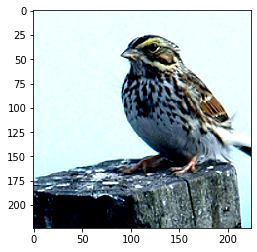

Ground Truth: 127.Savannah_Sparrow
Predicted: 127.Savannah_Sparrow ( 0.6365675330162048 )


In [39]:
output = model_(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = class_names[pred_label_idx.item()]
imshow(images[ind].cpu())
print('Ground Truth:', class_names[labels[ind]])
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

## Guided GradCAM

Guided GradCAM computes the element-wise product of guided backpropagation attributions with upsampled (layer) GradCAM attributions. GradCAM attributions are computed with respect to a given layer, and attributions are upsampled to match the input size. This approach is designed for convolutional neural networks. The chosen layer is often the last convolutional layer in the network, but any layer that is spatially aligned with the input can be provided.

Guided GradCAM was proposed by the authors of GradCAM as a method to combine the high-resolution nature of Guided Backpropagation with the class-discriminative advantages of GradCAM, which has lower resolution due to upsampling from a convolutional layer.

Refernce material:

    We propose a technique for making Convolutional Neural Network (CNN)-based models more transparent by visualizing the regions of input that are "important" for predictions from these models - or visual explanations. Our approach, called Gradient-weighted Class Activation Mapping (Grad-CAM), uses the class-specific gradient information flowing into the final convolutional layer of a CNN to produce a coarse localization map of the important regions in the image. Grad-CAM is a strict generalization of the Class Activation Mapping. Unlike CAM, Grad-CAM requires no re-training and is broadly applicable to any CNN-based architectures. We also show how Grad-CAM may be combined with existing pixel-space visualizations to create a high-resolution class-discriminative visualization (Guided Grad-CAM). We generate Grad-CAM and Guided Grad-CAM visual explanations to better understand image classification, image captioning, and visual question answering (VQA) models. In the context of image classification models, our visualizations (a) lend insight into their failure modes showing that seemingly unreasonable predictions have reasonable explanations, and (b) outperform pixel-space gradient visualizations (Guided Backpropagation and Deconvolution) on the ILSVRC-15 weakly supervised localization task. For image captioning and VQA, our visualizations expose the somewhat surprising insight that common CNN + LSTM models can often be good at localizing discriminative input image regions despite not being trained on grounded image-text pairs. Finally, we design and conduct human studies to measure if Guided Grad-CAM explanations help users establish trust in the predictions made by deep networks. Interestingly, we show that Guided Grad-CAM helps untrained users successfully discern a "stronger" deep network from a "weaker" one even when both networks make identical predictions.

In [40]:
guidedgradcam = GuidedGradCam(model_, model_.avgpool)

attributions_ggc = guidedgradcam.attribute(input, target=pred_label_idx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


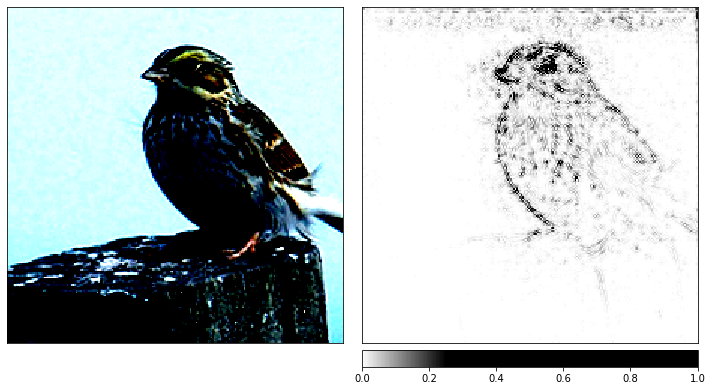

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


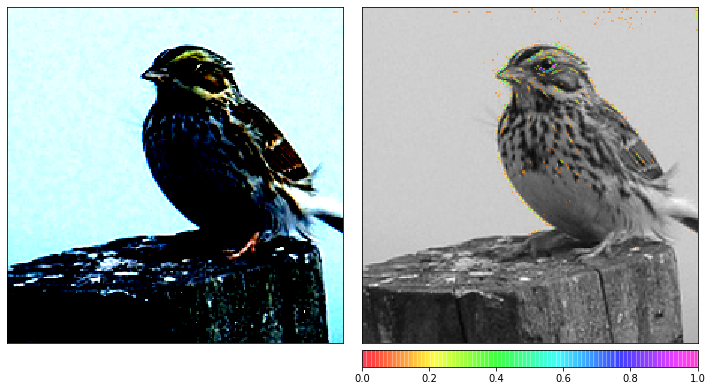

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


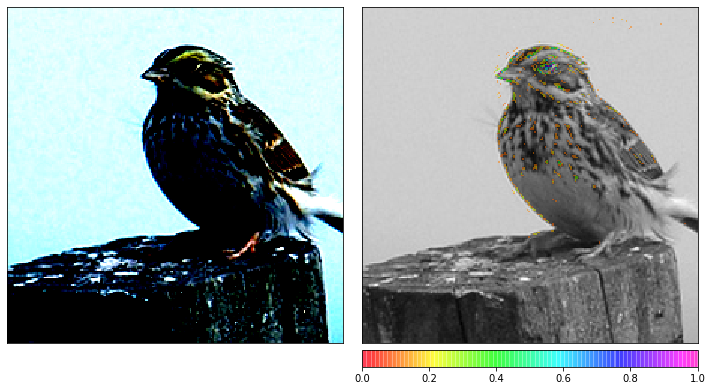

In [41]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ggc.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True,
                                      fig_size=(10,10))

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ggc.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "positive"],
                                      cmap='rainbow_alpha',
                                      show_colorbar=True,
                                      fig_size=(10,10))

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ggc.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "negative"],
                                      cmap='rainbow_alpha',
                                      show_colorbar=True,
                                      fig_size=(10,10))

## Gradient Shap

Gradient SHAP is a gradient method to compute SHAP values, which are based on Shapley values proposed in cooperative game theory. Gradient SHAP adds Gaussian noise to each input sample multiple times, selects a random point along the path between baseline and input, and computes the gradient of outputs with respect to those selected random points. The final SHAP values represent the expected value of gradients * (inputs - baselines).

The computed attributions approximate SHAP values under the assumptions that the input features are independent and that the explanation model is linear between the inputs and given baselines.

In [42]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model_)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


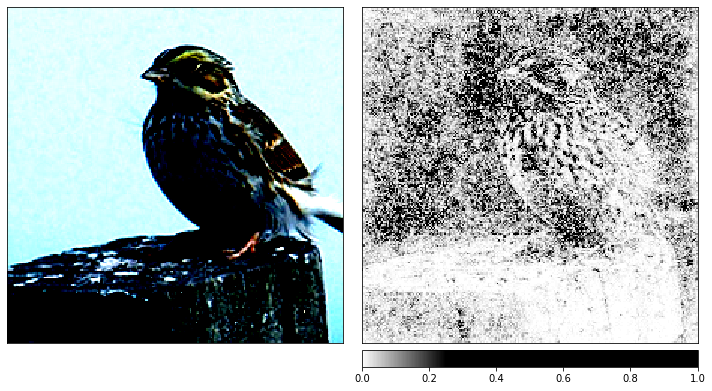

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


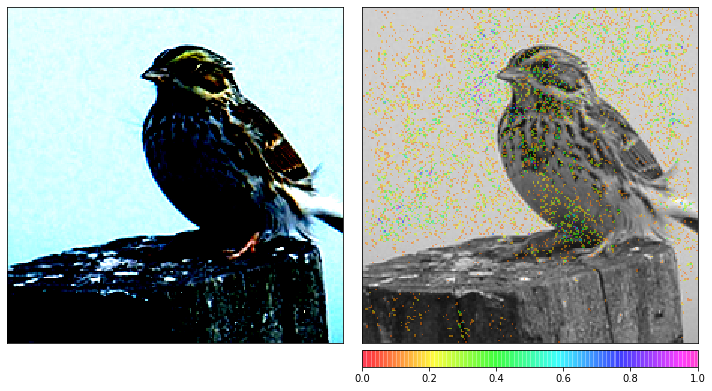

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


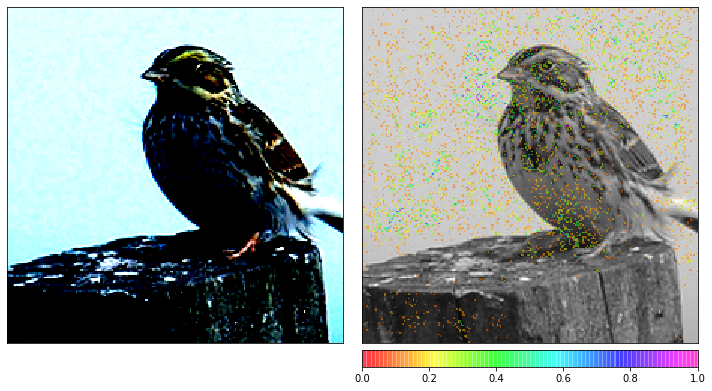

In [43]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True,
                                      fig_size=(10,10))

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "positive"],
                                      cmap='rainbow_alpha',
                                      show_colorbar=True,
                                      fig_size=(10,10))

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "negative"],
                                      cmap='rainbow_alpha',
                                      show_colorbar=True,
                                      fig_size=(10,10))

## Occlusion

Occlusion is a perturbation based approach to compute attribution, involving replacing each contiguous rectangular region with a given baseline / reference, and computing the difference in output. For features located in multiple regions (hyperrectangles), the corresponding output differences are averaged to compute the attribution for that feature. Occlusion is most useful in cases such as images, where pixels in a contiguous rectangular region are likely to be highly correlated.

Computes rolling window view of the input array and replace each window with zero values, measuring the effect of the perturbation on the target output.

The optional parameters window_shape and step behave like in skimage. By default, each feature is tested independently (window_shape=1 and step=1), however this might be extremely slow for large inputs (such as ImageNet images). When the input presents some local coherence (eg. images), you might prefer larger values for window_shape. In this case the attributions of the features in each window will be summed up. Notice that the result might vary significantly for different window sizes.

A **positive** attribution score indicates that the area of the image contributes to an increase in the prediction score.
    
A **negative** attribution score indicates that these areas are causing a distraction to the prediction score, and removal would increase the prediction score.

In [44]:
occlusion = Occlusion(model_)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


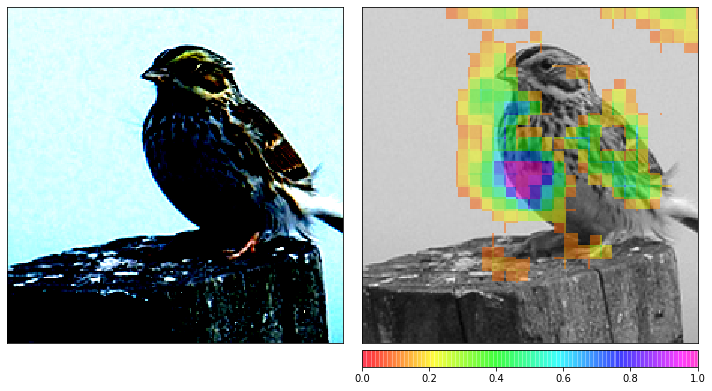

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


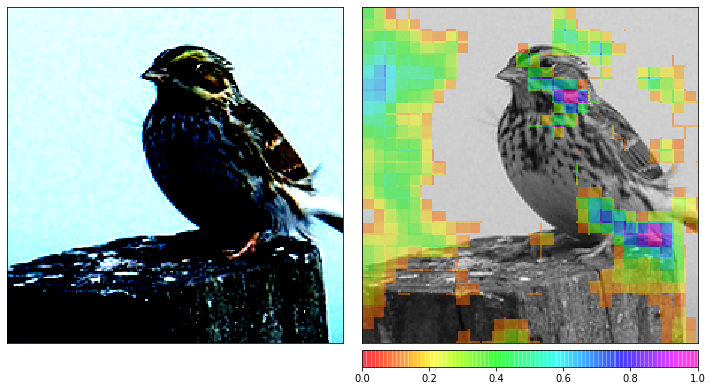

In [45]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,10),
                                      cmap='rainbow_alpha'
                                     )

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "negative"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,10),
                                      cmap='rainbow_alpha'
                                     )

## Shapley Value Sampling

Shapley value is an attribution method based on a concept from cooperative game theory. This method involves taking each permutation of the input features and adding them one-by-one to a given baseline. The output difference after adding each feature corresponds to its contribution, and these differences are averaged over all permutations to obtain the attribution.

Since this method is extremely computationally intensive for larger numbers of features, we also implement Shapley Value Sampling, where we sample some random permutations and average the marginal contribution of features based on these permutations. Like feature ablation, input features can also be grouped and added together rather than individually.

In [ ]:
shapley = ShapleyValueSampling(model_)

rand_img_dist = torch.cat([input * 0, input * 1])

attributions_svs = shapley.attribute(input, 
                                     target=pred_label_idx, 
                                     n_samples=25, 
                                     baselines=rand_img_dist)

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_svs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,10),
                                      cmap='rainbow_alpha'
                                     )

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_svs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "negative"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,10),
                                      cmap='rainbow_alpha'
                                     )

In [ ]:
deeplift = DeepLift(model_)

attributions_dl = deeplift.attribute(input,
                                     target=pred_label_idx)

In [ ]:
deepliftshap = DeepLiftShap(model_)

rand_img_dist = torch.cat([input * 0, input * 1])

attributions_dls = deepliftshap.attribute(input,
                                          target=pred_label_idx,
                                          baselines=rand_img_dist)